# The DTD from double-detonation sub-Chandrasekhar mass models

Ruiter et al. (2011)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath('../src/scripts'))

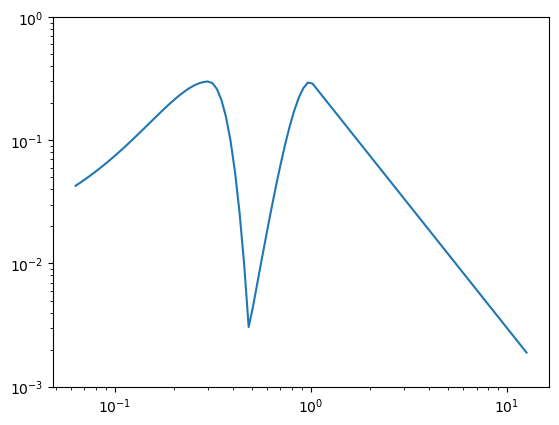

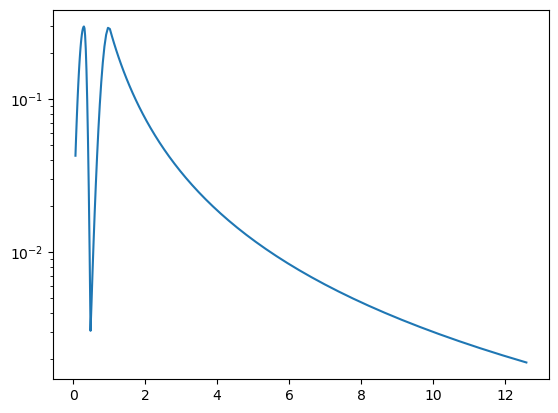

In [49]:
from multizone.src.dtds.utils import gaussian

class SubMChDTD:
    def __init__(self):
        self.peak1 = 0.3
        self.peak2 = 0.3
        self.prompt_rise = gaussian(center=0.3, stdev=0.12, coeff=self.peak1, normalize=False)
        self.prompt_fall = gaussian(center=0.3, stdev=0.06, coeff=self.peak1, normalize=False)
        self.delayed_rise = gaussian(center=1., stdev=0.17, coeff=self.peak2, normalize=False)
    
    def __call__(self, time):
        if time < 0.3:
            return self.prompt_rise(time)
        elif time < 0.5:
            return self.prompt_fall(time) 
        elif time < 1.:
            return self.delayed_rise(time)
        else:
            return self.peak2 * time ** -2

tarr = np.logspace(-1.2, 1.1, 100)
func = SubMChDTD()
plt.loglog(tarr, [func(t) for t in tarr])
plt.ylim((1e-3, 1))
plt.show()

plt.semilogy(tarr, [func(t) for t in tarr])

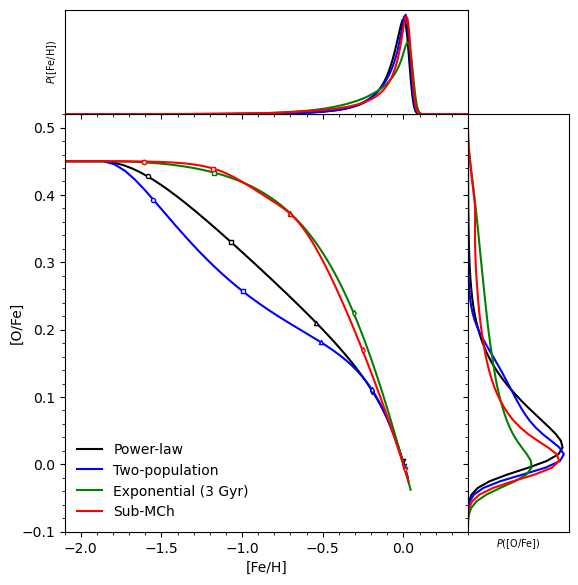

In [57]:
from multizone.src.dtds import prompt, powerlaw, exponential
from track_and_mdf import setup_figure, plot_vice_onezone
from _globals import END_TIME, ONEZONE_DEFAULTS
import vice
from multizone.src.yields import J21
from multizone.src import models
import paths

output_dir = paths.data / 'onezone' / 'sub_chandra_dtd'
if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig, axs = setup_figure(width=6)

dt = ONEZONE_DEFAULTS['dt']
simtime = np.arange(0, END_TIME + dt, dt)

delay = ONEZONE_DEFAULTS['delay']
distributions = [powerlaw(slope=-1.1), prompt(), exponential(timescale=3), SubMChDTD()]
names = ['plaw', 'twopop', 'exp', 'submch']
labels = ['Power-law', 'Two-population', 'Exponential (3 Gyr)', 'Sub-MCh']
colors = ['k', 'b', 'g', 'r']

for i, dtd in enumerate(distributions):
    sz = vice.singlezone(name=str(output_dir / names[i]),
                         RIa=dtd,
                         func=models.insideout(8, dt=dt), 
                         mode='sfr',
                         **ONEZONE_DEFAULTS)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(str(output_dir / names[i]), 
                      fig=fig, axs=axs,
                      label=labels[i], 
                      color=colors[i],
                      linestyle='-',
                      marker_labels=False,
                      )

# Re-scale marginal axis limits
axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)

axs[0].legend(frameon=False, loc='lower left', handlelength=1.8)
plt.show()